# **Machine Learning for Factor Investing**

This notebook implements and expands on the ideas presented in [Coqueret and Guida (2021)](http://www.mlfactor.com/), please refer to their book as it provides a really good, data-oriented introduction to quantitative equity investing. My goal in this exercise is for nothing more than my own practice and learning, and all credit goes to the original authors.

I recommend running this notebook on [Google Colab](https://colab.research.google.com/), where you can up and running in only a few seconds. You might just need to download the [original data](https://github.com/shokru/mlfactor.github.io/blob/master/material/data_ml.RData) to your Google Drive.

### **Chapter 0.** Importing stuff and setup

In [1]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange
from dateutil.relativedelta import relativedelta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['patch.facecolor'] = 'white' # This is helpful if you're using Colab in dark mode
plt.rcParams['figure.figsize'] = 15, 7
# import graphviz

# Reading Rdata - need to install in Collab
# !pip install pyreadr
import pyreadr

# Regression type stuff
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from portfolio import *
# # Trees
# from sklearn import tree
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
# # from xgboost import XGBClassifier

# # Deep learning stuff
# import tensorflow as tf
# from tensorflow import keras

/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_5834/574601892.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### **Chapter 1.** Notations and data

Mostly ingesting the data and some quick and dirty data cleaning as well as initial exploration.

In [2]:
Rdata = pyreadr.read_r('../data/data_ml.RData')

data = Rdata['data_ml']
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

data.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,...,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


In [2]:
universe = pd.read_csv("../data/ibov_universe.csv",index_col=None)


universe = Portifolio(universe)
data = universe.pre_processing()
numeric_columns = universe.numeric_columns


/Users/zanchitta/Documents/ITA/PO-245/Fama-French-Factor-Models/src/portfolio.py:211: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  self.frame['data_da_analise'] = pd.to_datetime(self.frame['data_da_analise'])


In [19]:
# bigest returns:
data[['ticker','ret12m']].sort_values(by='ret12m', ascending=False).head(30)
data = data.drop(index = [1151,963,964,990,579,883,868,274])
# data.loc[data['ticker'] == 'GGBR4',['date','ret12m','fator_cotacao','mkt_value','size','closed_price']]
# if fator_cotacao changes than display index:
    

[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014'),
 Text(15, 0, '2015'),
 Text(16, 0, '2016'),
 Text(17, 0, '2017'),
 Text(18, 0, '2018'),
 Text(19, 0, '2019'),
 Text(20, 0, '2020'),
 Text(21, 0, '2021'),
 Text(22, 0, '2022')]

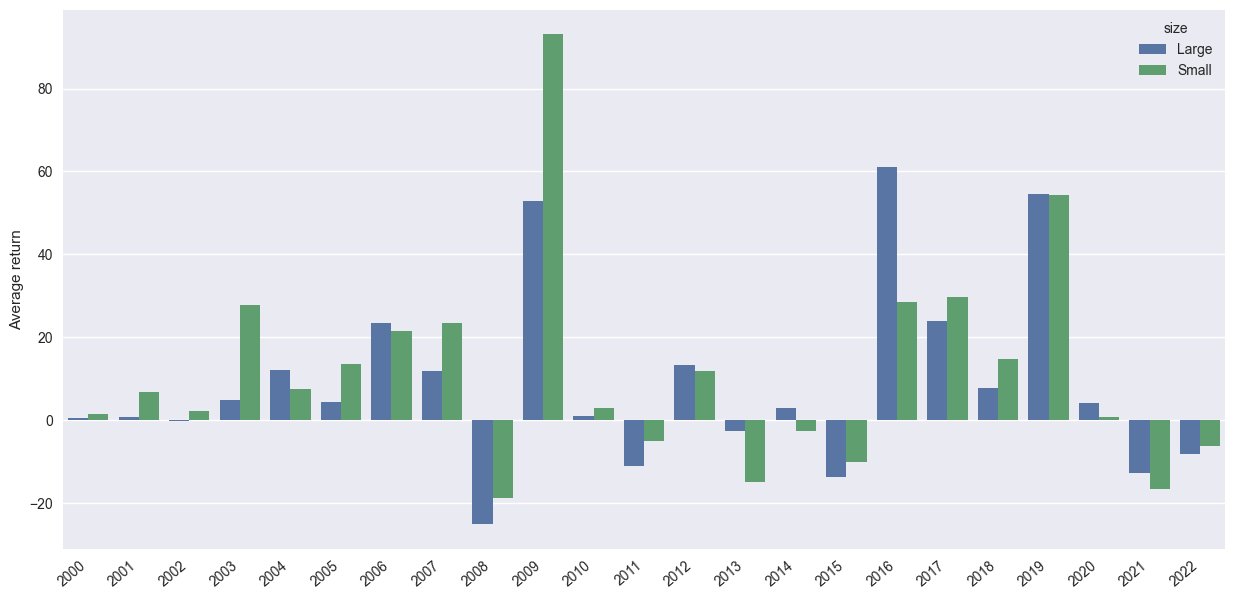

In [20]:
data['size'] = data.groupby('date')['mkt_value'].apply(lambda x: (x > x.median())).reset_index(drop=True).replace({True: 'Large', False: 'Small'})
data['year'] = data['date'].dt.year

return_by_size = data.groupby(['year', 'size'])['ret12m'].mean().reset_index()

ax = sns.barplot(x='year', y='ret12m', hue='size', data=return_by_size)
ax.set(xlabel='', ylabel='Average return')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [4]:
data.head()

,ticker,name,date,net_worth,qnt,ebit12m,closed_price,ativo_total,fator_cotacao,ret12m,ret6m,ret3m,ret1m,liq_corr,vol12m,vol6m,vol3m,vol1m,entreprise_value,mkt_value
0,ABEV3,AMBEV S/A,2022-12-29,8.643687e+10,1.575383e+10,18412913000,14.52,1.354667e+11,1,-0.875125,14.067580,-1.640568,-3.988344,0.992880,24.551790,23.928674,24.563946,18.336817,2.126138e+11,2.286932e+11
1,ALPA4,ALPARGATAS,2022-12-29,5.512355e+09,6.830622e+08,23403000,15.08,8.127527e+09,1,-59.084942,-21.212121,-29.102022,-9.970149,2.496223,55.398722,61.196884,63.988089,59.822397,9.361016e+09,9.220934e+09
2,AMER3,AMERICANAS,2022-12-29,1.470556e+10,9.097745e+08,1165519000,9.65,4.708413e+10,1,-68.832343,-28.145942,-43.168433,-8.617424,2.240903,78.138246,90.704685,85.283618,72.447712,2.097531e+10,8.779324e+09
3,ARZZ3,AREZZO CO,2022-12-29,2.741961e+09,1.101861e+08,493801000,78.25,5.131922e+09,1,4.440704,14.695724,-19.676322,-11.748876,1.692919,38.165783,39.791913,45.684485,44.448728,8.487425e+09,8.622061e+09
4,ASAI3,ASSAI,2022-12-29,3.980000e+09,1.350256e+09,2896000000,19.47,3.908900e+10,1,51.740298,36.700821,11.152178,-2.707196,0.807805,35.420312,35.197509,43.540761,34.983777,3.417704e+10,2.625204e+10


Visualização da quantidade de ativos por data, podemos verificar que o ibov cresceu em número de ações ordinárias ao longo do tempo.

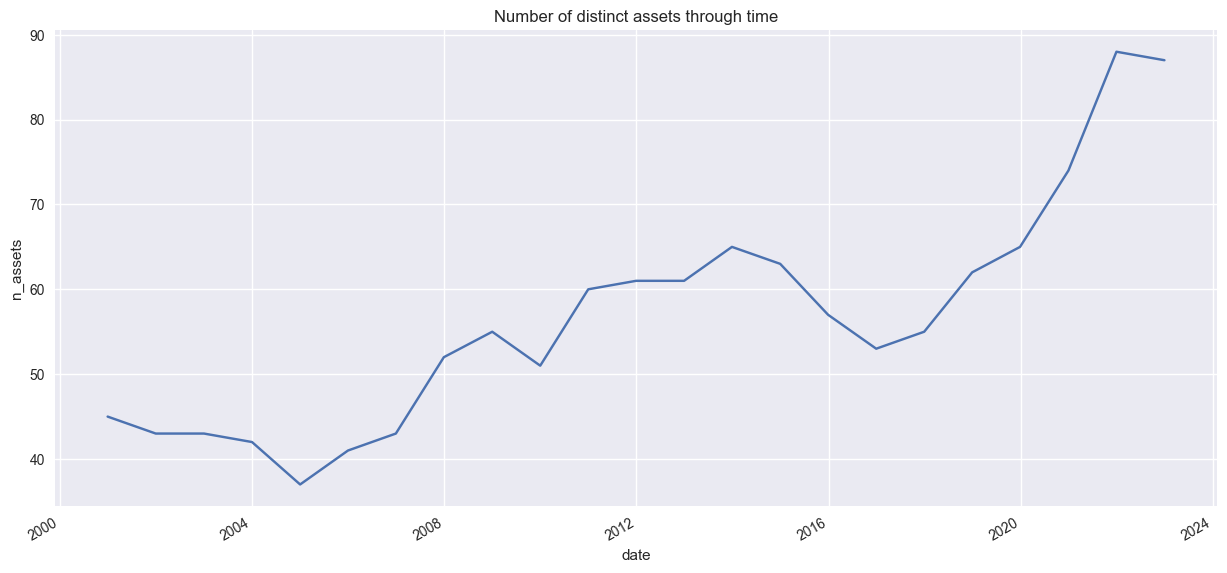

In [5]:
data.groupby('date')['ticker'].count().plot(ylabel='n_assets',title='Number of distinct assets through time');

Vamos normalizar as colunas numéricas:

In [6]:
numeric_columns

['net_worth',
 'qnt',
 'ret12m',
 'ret6m',
 'ret3m',
 'ret1m',
 'closed_price',
 'ebit12m',
 'fator_cotacao',
 'ativo_total',
 'vol12m',
 'vol6m',
 'vol3m',
 'vol1m',
 'mkt_value',
 'liq_corr',
 'entreprise_value']

In [18]:
#normalize numerical columns:
# import minmax scaler
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
transformer = scaler.fit(data[numeric_columns])
data[numeric_columns] = transformer.transform(data[numeric_columns])

#removendo elementos que estejam fora de 3 desvios padrões
data = data[(np.abs(data[numeric_columns]) < 3).all(axis=1)]

verificando normalização:

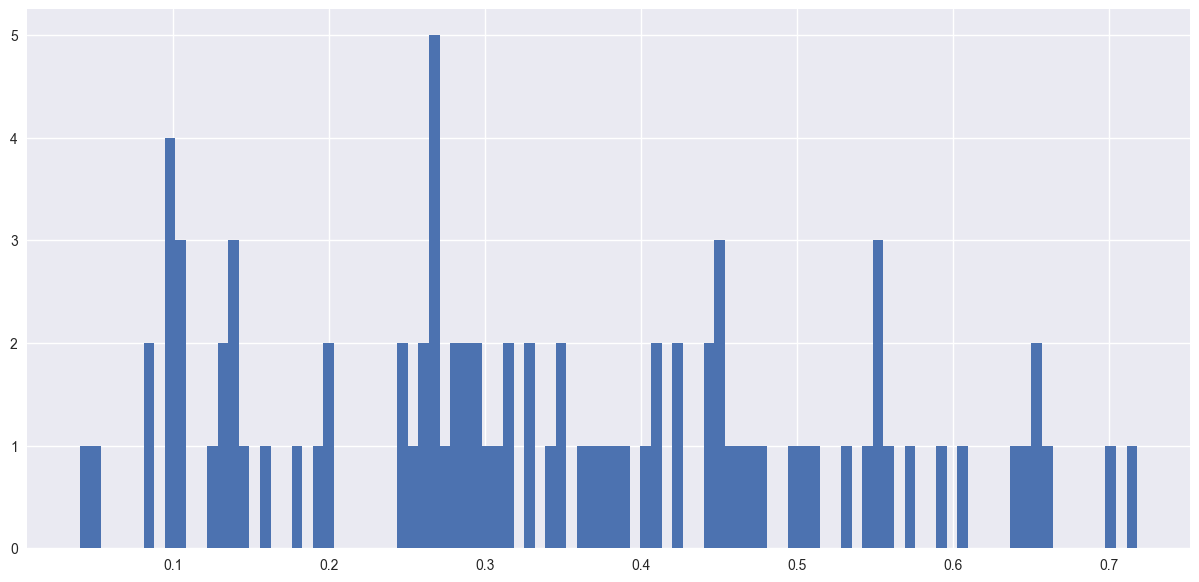

In [19]:
data.loc[(data['date']=='2022-12-29'),'mkt_value'].hist(bins=100); 


In [20]:
features = data.columns.to_list()[3:-7]
features_short = ["ebit12m", "ativo_total", "net_worth", "liq_corr","vol12m", "mkt_value", "entreprise_value"] 

In [21]:
features

['net_worth',
 'qnt',
 'ebit12m',
 'closed_price',
 'ativo_total',
 'fator_cotacao',
 'ret12m',
 'ret6m',
 'ret3m',
 'ret1m',
 'liq_corr',
 'vol12m']

#### Separação de amostra de treino e teste

In [22]:
#find separation_date:
separation_date = data['date'].unique()[int(len(data['date'].unique())*0.8)]
print(f'separation_date: {separation_date}')

separation_date: 2004-12-30 00:00:00


In [23]:
separation_mask = (data['date'] < separation_date)

training_sample = data.loc[separation_mask]
testing_sample = data.loc[~separation_mask]

In [24]:
stock_ids = data['ticker'].unique().tolist()

max_dates = data.groupby('ticker')['date'].count().max()
stocks_with_max_dates = data.groupby('ticker')['date'].count() == max_dates
stock_ids_short = stocks_with_max_dates.where(stocks_with_max_dates).dropna().index.tolist() # these are stocks who have data for all timestamps

returns = data[data['ticker'].isin(stock_ids_short)][['date','ticker','ret1m']]
returns = returns.pivot(index='date',columns='ticker');

## Factor Investing


Vamos agrupar os dados do nosso universo e realizar a segmentação das ações por tamanho, no

In [25]:
data['mkt_value'].describe()
# data.groupby('date')['VM'].apply(lambda x: (x > x.median()))

count    1303.000000
mean        0.278184
std         0.199164
min         0.000000
25%         0.108005
50%         0.255282
75%         0.421347
max         0.737978
Name: mkt_value, dtype: float64

[Text(0, 0, '2000'),
 Text(1, 0, '2001'),
 Text(2, 0, '2002'),
 Text(3, 0, '2003'),
 Text(4, 0, '2004'),
 Text(5, 0, '2005'),
 Text(6, 0, '2006'),
 Text(7, 0, '2007'),
 Text(8, 0, '2008'),
 Text(9, 0, '2009'),
 Text(10, 0, '2010'),
 Text(11, 0, '2011'),
 Text(12, 0, '2012'),
 Text(13, 0, '2013'),
 Text(14, 0, '2014'),
 Text(15, 0, '2015'),
 Text(16, 0, '2016'),
 Text(17, 0, '2017'),
 Text(18, 0, '2018'),
 Text(19, 0, '2019'),
 Text(20, 0, '2020'),
 Text(21, 0, '2021'),
 Text(22, 0, '2022')]

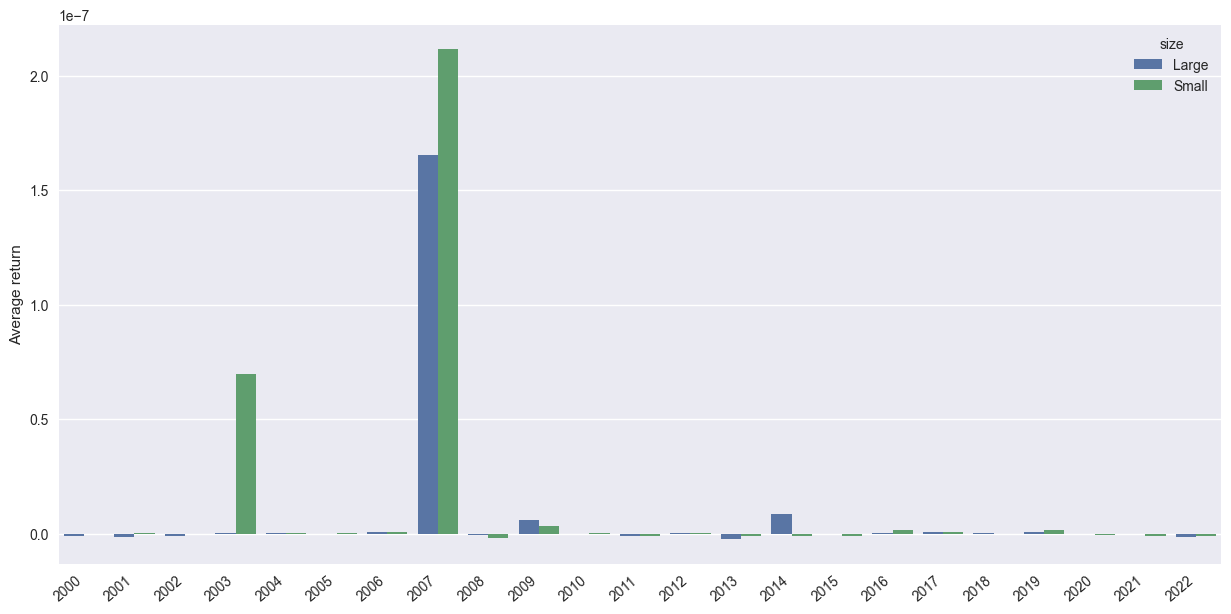

In [26]:
data['size'] = data.groupby('date')['mkt_value'].apply(lambda x: (x > x.median())).reset_index(drop=True).replace({True: 'Large', False: 'Small'})
data['year'] = data['date'].dt.year

return_by_size = data.groupby(['year', 'size'])['ret12m'].mean().reset_index()

ax = sns.barplot(x='year', y='ret12m', hue='size', data=return_by_size)
ax.set(xlabel='', ylabel='Average return')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


In [27]:
data[['ticker','ret12m','date']].sort_values(by='ret12m',ascending=False).head(10)

,ticker,ret12m,date
964,BRTP3,5.077366e-06,2007-12-28
963,BRTO4,3.664341e-06,2007-12-28
1151,GGBR4,1.896602e-06,2003-12-30
990,PCAR4,9.646609e-07,2007-12-28
579,KLBN11,2.642237e-07,2014-12-29
889,RSID3,6.523842e-08,2009-12-30
883,MMXM3,5.622165e-08,2009-12-30
872,GFSA3,2.196523e-08,2009-12-30
868,DTEX3,1.640448e-08,2009-12-30
298,QUAL3,1.564633e-08,2019-12-27


In [28]:
#lendo os fatores:
ff_factors = pd.read_csv("../data/risk_factors/factors.csv",index_col=None)
# ajustando os tipos das colunas:
ff_factors['date'] = pd.to_datetime(ff_factors['date'])
# ff_factors['date'] = ff_factors['date'].dt.strftime("%Y/%m/%d")
ff_factors.rename({'Risk_free':'RF','Rm_minus_Rf':'MKT_RF'}, axis = 1, inplace=True)
columns_to_float = ff_factors.columns[1:]
ff_factors[columns_to_float] = ff_factors[columns_to_float].astype(float)
display(ff_factors.head())

,date,MKT_RF,HML,IML,SMB,WML,RF
0,2001-01-02,0.006601,0.065490,0.014109,0.000524,-0.006308,0.000579
1,2001-01-03,0.062427,0.009390,0.004510,0.005390,-0.028644,0.000577
2,2001-01-04,-0.000310,-0.002327,-0.009227,0.006690,-0.000946,0.000574
3,2001-01-05,-0.012839,-0.002397,0.025124,0.003523,0.005985,0.000573
4,2001-01-08,0.003982,0.001948,-0.001175,0.007883,-0.004099,0.000573


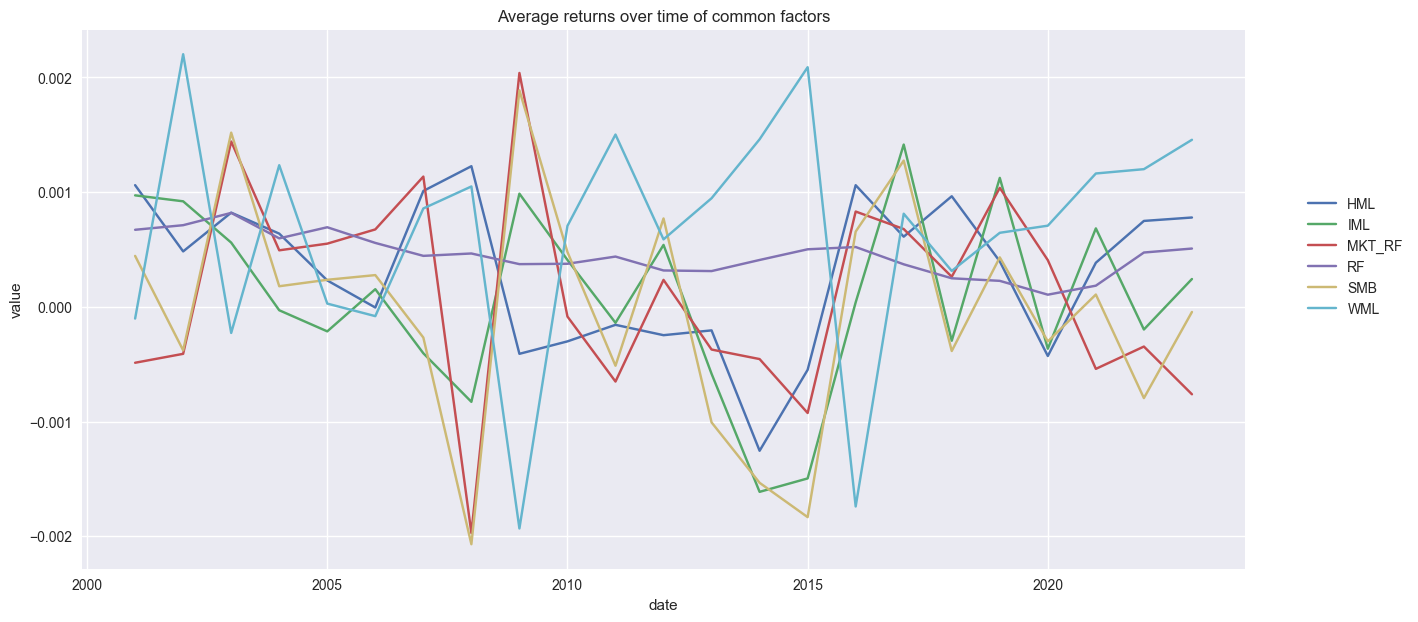

In [29]:
temp_factors = ff_factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()

plt = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors);
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.);
plt.set_title('Average returns over time of common factors');
# replicating this from the book for completeness only, but i think it's a pretty messy chart 
# it's hard to take much insight from it

<Axes: title={'center': 'Cumulative factor performance since January 2001'}>

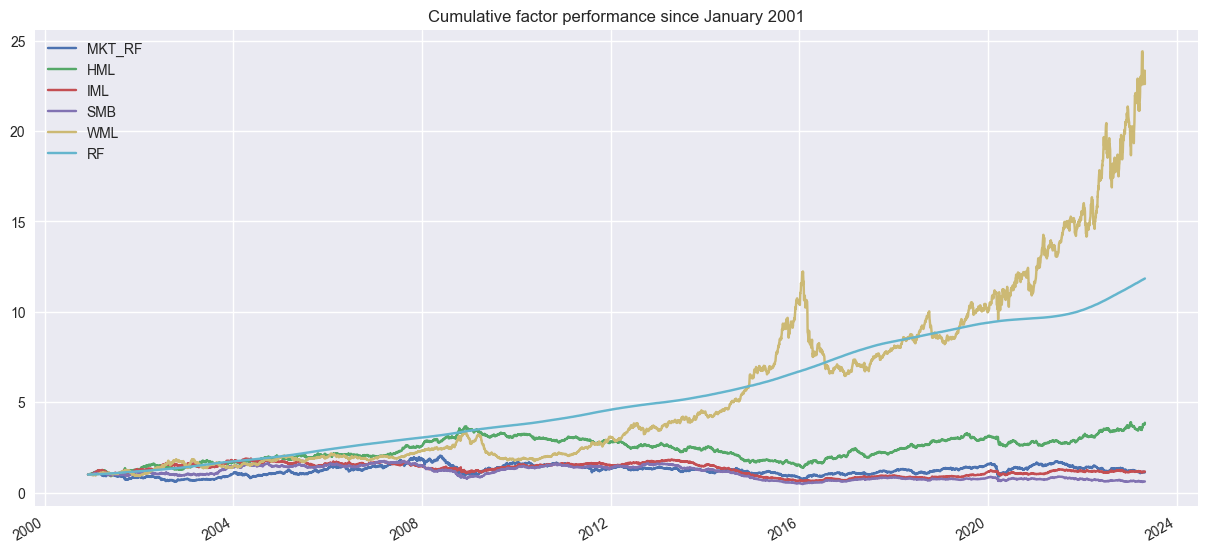

In [30]:
# let's see how factors cumulative performance over time
# but wrap that in a function that allows you to choose the start period (as that influences cumulative performance a lot)

def plot_cumulative_performance(df, start_date = None):

  # this function will plot cumulative performance for any wide dataframe of returns (e.g. index is date, columns are assets/factor)
  # optional: you can pass the start date in %m/%d/%y format e.g. '1/1/1995', '12/15/2000'
  # if you don't pass a start date, it will use the whole sample

  cumul_returns = (1+df.set_index('date')).cumprod()

  if start_date is None:
    start_date = cumul_returns.index.min()
  else:
    start_date = datetime.strptime(start_date, '%m/%d/%Y')
    cumul_returns = cumul_returns.loc[cumul_returns.index >= start_date]

  first_line = pd.DataFrame([[1. for col in cumul_returns.columns]],
                            columns = cumul_returns.columns,
                            index = [start_date - relativedelta(months=1)])

  cumul_returns = pd.concat([first_line,cumul_returns])

  return cumul_returns.plot(title = f'Cumulative factor performance since {start_date.strftime("%B %Y")}')

plot_cumulative_performance(ff_factors)

Below we perform **Fama-Macbeth regressions**, which is the standard way of validating a factor's risk premium in the cross-section of stock returns. As we will see, this involves a two-step process of:

*   Time-series regression: regress each asset's returns on factors, i.e. one regression per asset. Store the coefficients.
*   Cross-section regression: regress each asset's returns on coefficients obtained in previous step, i.e. one regression per time period.


In [31]:
# merging and cleaning up the data before we run the regressions
data_fm = data[['date','ticker','ret1m']][data['ticker'].isin(stock_ids_short)]
data_fm = data_fm.merge(ff_factors, on = 'date')
data_fm['ret1m'] = data_fm.groupby('ticker')['ret1m'].shift(1)
data_fm.dropna(inplace=True)

# running time series regressions

reg_output = {}

for k,g in data_fm.groupby('ticker'):
  model = ols('ret1m ~ MKT_RF + SMB + HML + WML + IML', data=g)
  results = model.fit()

  reg_output[k] = results.params

betas = pd.DataFrame.from_dict(reg_output).T
betas.head()

,Intercept,MKT_RF,SMB,HML,WML,IML
BBAS3,2.984889e-13,-3.689061e-11,2.722655e-10,6.970796e-11,6.099663e-11,-2.705771e-10
BBDC4,9.106803e-13,7.366769e-11,-7.278835e-11,-3.734883e-12,1.575154e-10,-1.049674e-11
BRAP4,3.348301e-10,8.569816e-09,-3.556661e-08,4.776864e-08,4.395098e-08,-5.269203e-09
CMIG4,6.176679e-11,-3.400345e-10,-6.426513e-09,3.907505e-09,1.725440e-10,-5.409598e-10
CSNA3,4.777403e-11,-2.327707e-09,4.008798e-09,5.657986e-09,5.235228e-09,-3.546903e-09


In [59]:
betas.describe()

,Intercept,MKT_RF,SMB,HML,WML,IML
count,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01,1.000000e+01
mean,6.523370e-11,9.096165e-10,-3.149757e-09,7.644383e-09,5.546588e-09,-2.786393e-09
std,1.025180e-10,3.880471e-09,1.191595e-08,1.451219e-08,1.358229e-08,3.532395e-09
min,-3.175058e-13,-3.634236e-09,-3.556661e-08,-3.734883e-12,6.099663e-11,-1.147093e-08
25%,8.120137e-13,-3.352970e-10,-1.765161e-09,2.385359e-10,2.809927e-10,-3.435361e-09
50%,3.050781e-11,-1.488476e-10,2.645044e-10,3.133418e-09,7.729236e-10,-1.651832e-09
75%,8.194790e-11,1.718013e-10,7.469711e-10,5.612291e-09,2.047052e-09,-4.280088e-10
max,3.348301e-10,8.569816e-09,6.940836e-09,4.776864e-08,4.395098e-08,-1.049674e-11


In [33]:
# prepping coeficient data to run second round of regressions
loadings = betas.drop('Intercept', axis = 1).reset_index(drop=True)
ret = returns.T.reset_index(drop=True)
fm_data = pd.concat([loadings,ret], axis=1)
fm_data = pd.melt(fm_data,id_vars=['MKT_RF','SMB','HML','WML','IML'])

# running cross section regressions

reg_output_2 = {}

for k,g in fm_data.groupby('variable'):
  model = ols('value ~ MKT_RF + SMB + HML + WML + IML', data=g)
  results = model.fit()

  reg_output_2[k] = results.params

# refer to the mlfactor book or the fama-macbeth literature for more info on what the gammas stand for
# but you can think of them as an estimate of a given factor's risk premium at a point in time
gammas = pd.DataFrame.from_dict(reg_output_2).T.reset_index().rename({'index':'date'}, axis = 1)
gammas.head()

,date,Intercept,MKT_RF,SMB,HML,WML,IML
0,2000-12-27,-8.221775e-13,-0.017082,-0.033396,-0.019110,0.036686,-0.039945
1,2001-12-28,2.368666e-11,-0.014371,-0.013935,0.012224,-0.007600,0.006195
2,2002-12-30,7.432160e-12,-0.022565,-0.021699,0.014824,-0.002302,-0.007604
3,2003-12-30,4.877728e-13,0.027749,-0.027782,0.026260,0.029744,-0.012482
4,2004-12-30,6.494738e-12,0.029043,-0.007134,-0.000175,-0.002229,-0.025474


In [34]:
fm_data.head()

,MKT_RF,SMB,HML,WML,IML,variable,value
0,-3.689061e-11,2.722655e-10,6.970796e-11,6.099663e-11,-2.705771e-10,2000-12-27,2.137692e-12
1,7.366769e-11,-7.278835e-11,-3.734883e-12,1.575154e-10,-1.049674e-11,2000-12-27,-6.673642e-13
2,8.569816e-09,-3.556661e-08,4.776864e-08,4.395098e-08,-5.269203e-09,2000-12-27,1.947236e-09
3,-3.400345e-10,-6.426513e-09,3.907505e-09,1.725440e-10,-5.409598e-10,2000-12-27,1.880327e-10
4,-2.327707e-09,4.008798e-09,5.657986e-09,5.235228e-09,-3.546903e-09,2000-12-27,1.637850e-10


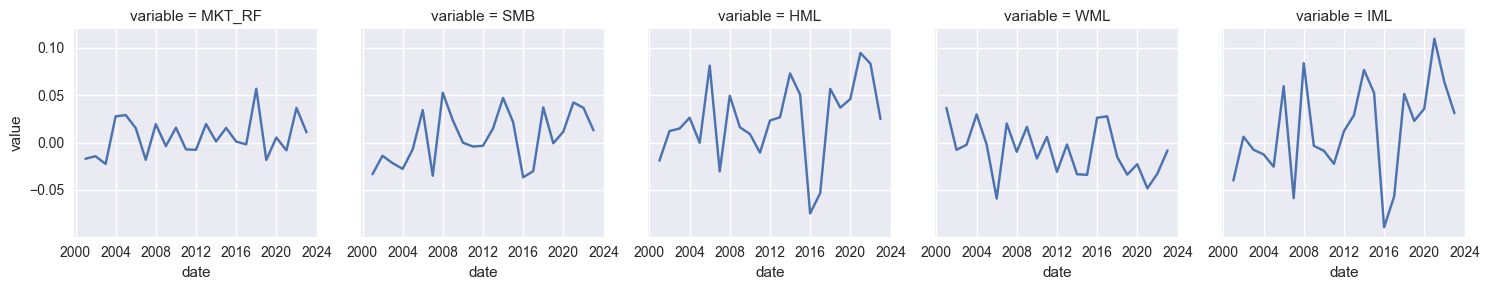

In [35]:
# since we get one estimate of that risk premium for each time step, we can plot how it evolves over time
x = pd.melt(gammas.drop('Intercept',axis=1), id_vars='date')

g = sns.FacetGrid(x, col='variable')
g.map(sns.lineplot, 'date', 'value')

Below we deploy the factor competition strategy outlined in the book. The main idea here is to regress a factor on the remaining factors and test whether the coefficient is significant. A significant coefficient means that the factors on the right-hand side don't completely explain the factor on the left-hand side, which naturally means the latter is useful.


In [36]:
factor_comp = pd.melt(ff_factors.drop('RF',axis=1),id_vars='date')

factor_comp = factor_comp.merge(ff_factors.drop('RF',axis=1), on = 'date')

factor_comp_coefs = {}
factor_comp_tstats = {}

for k,g in factor_comp.groupby('variable'):

  reg_data = g.drop([k,'date','variable'],axis=1)
  formula = 'value ~ ' + ' + '.join(reg_data.columns.values[1:].tolist())
  
  model = ols(formula, data=reg_data)
  results = model.fit()

  factor_comp_coefs[k] = results.params
  factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,HML,IML,Intercept,MKT_RF,SMB,WML
HML,NaN,5.755685,2.453682,14.145168,6.182620,-2.503500
IML,5.755685,NaN,1.226122,-32.784479,86.952400,4.493869
MKT_RF,14.145168,-32.784479,1.237863,NaN,14.168563,-6.969435
SMB,6.182620,86.952400,-0.478255,14.168563,NaN,-19.110036
WML,-2.503500,4.493869,4.515045,-6.969435,-19.110036,NaN


In [37]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + ' (**)'
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + ' (*)'

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[['Intercept'] + factors].reindex(factors)

alphas_table

,Intercept,MKT_RF,HML,IML,SMB,WML
MKT_RF,0.0,nan,0.306 (**),-0.99,0.447 (**),-0.127
HML,0.0 (*),0.114 (**),nan,0.116 (**),0.121 (**),-0.028
IML,0.0,-0.165,0.051 (**),nan,0.739 (**),0.033 (**)
SMB,-0.0,0.079 (**),0.057 (**),0.782 (**),nan,-0.142
WML,0.001 (**),-0.069,-0.04,0.109 (**),-0.437,nan


Below we explore factor time series momentum by looking at the partial auto-correlation functions. The shaded lines are confidence intervals, which the *statsmodels* library handily calculates for us by default (at 5% confidence levels).


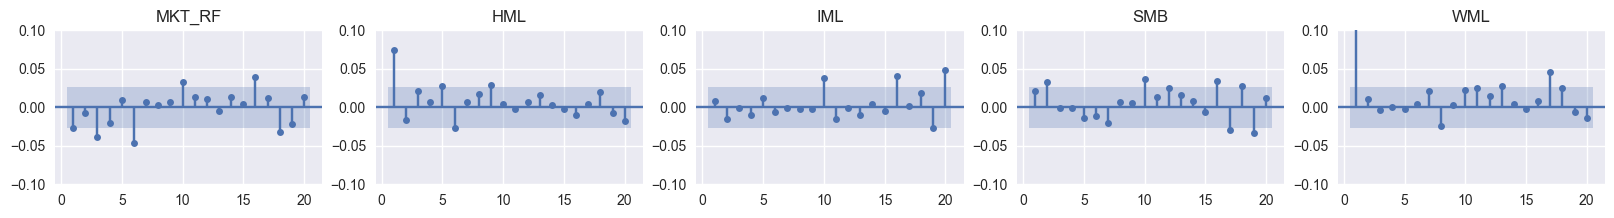

In [38]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

nfactors = len(factors)

# Plot y from -0.1 to 0.1:
fig, axs = plt.subplots(ncols=nfactors, figsize=(20, 2))

for i, factor in enumerate(factors):
    plot_pacf(ff_factors[factor], ax=axs[i], lags=20, zero=False, title=factor)
    axs[i].set_ylim(-0.1, 0.1)

plt.show()

### **Chapter 4.** Data preprocessing

In [39]:
features_short

['ebit12m',
 'ativo_total',
 'net_worth',
 'liq_corr',
 'vol12m',
 'mkt_value',
 'entreprise_value']

<Axes: xlabel='ret1m', ylabel='level_1'>

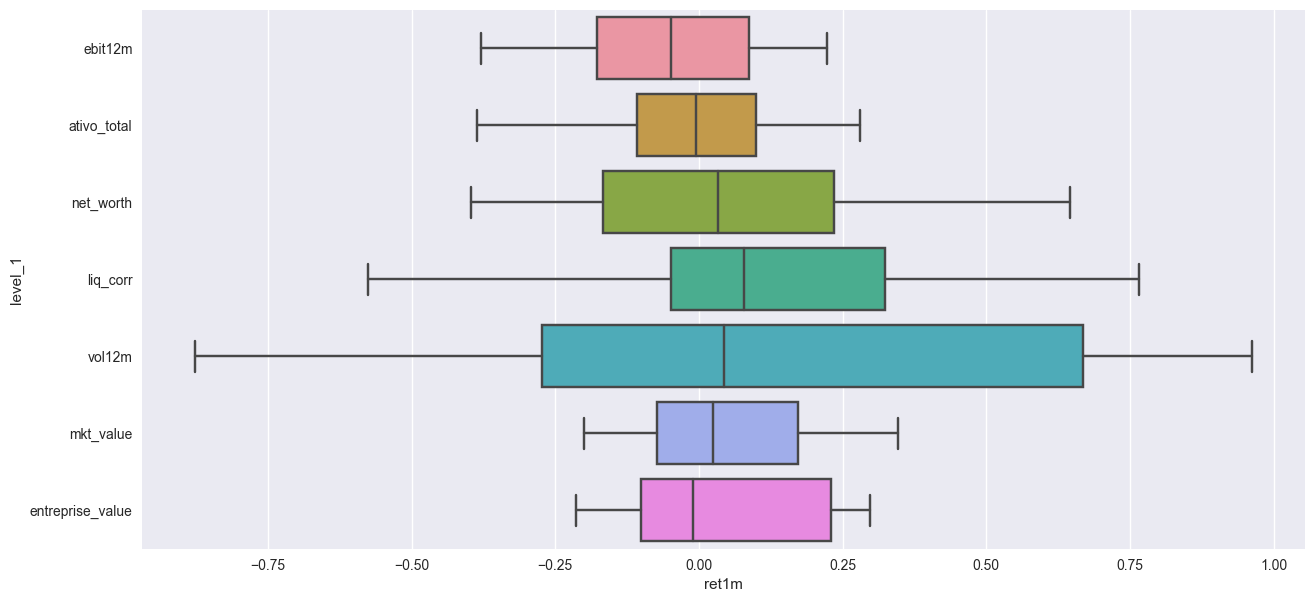

In [40]:
cols_to_keep = features_short+['ret1m','date']
corr_data = data[cols_to_keep]
corr_data = corr_data.groupby('date').corr()[['ret1m']].reset_index()
corr_data = corr_data.loc[corr_data['level_1']!='ret1m']

sns.boxplot(x='ret1m',y='level_1', data = corr_data)

<Axes: xlabel='value', ylabel='ret1m'>

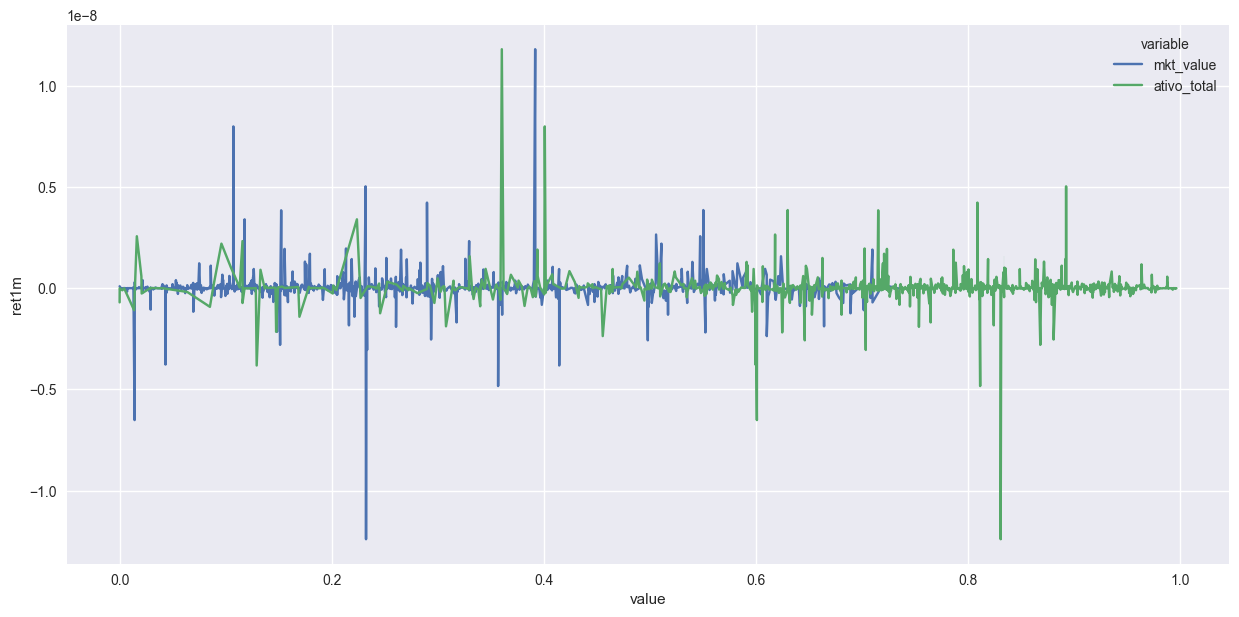

In [43]:
x = pd.melt(data[['ret1m','mkt_value','ativo_total']], id_vars='ret1m')

sns.lineplot(data = x, y='ret1m', x='value', hue='variable')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


<Axes: >

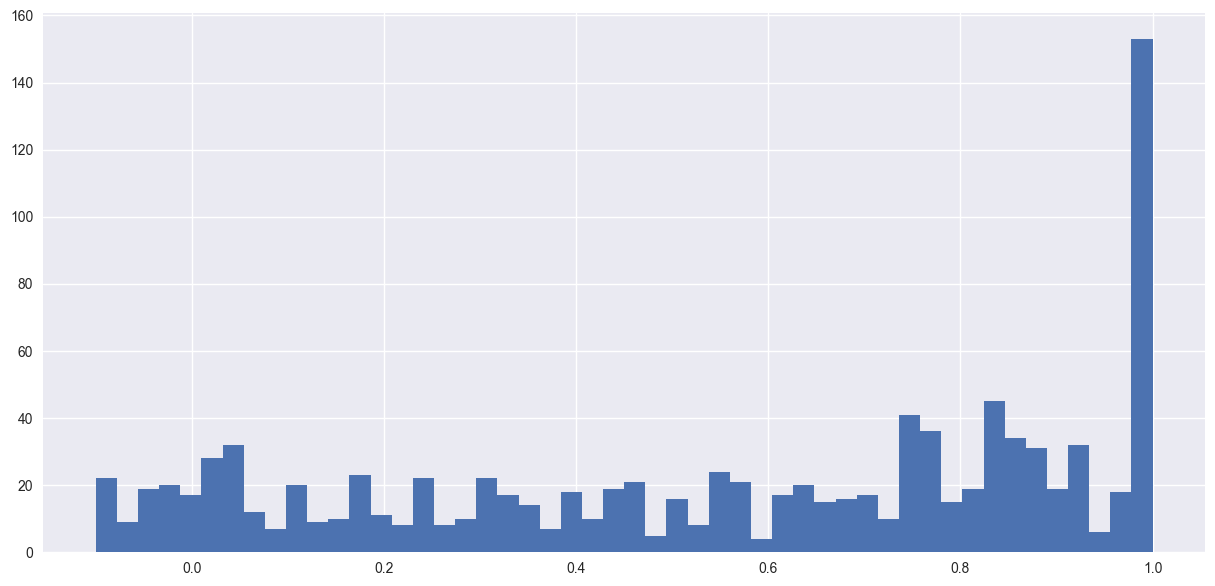

In [44]:
cols_to_keep = ['ticker'] + features

pd.melt(data[cols_to_keep], id_vars='ticker').groupby(['ticker','variable']).apply(lambda x: x['value'].autocorr(lag=1)).hist(bins=50,range=[-0.1,1])

The below is the "impact of rescaling" exercise done in the book. Note that it's purely numerical - it does not use data at all.

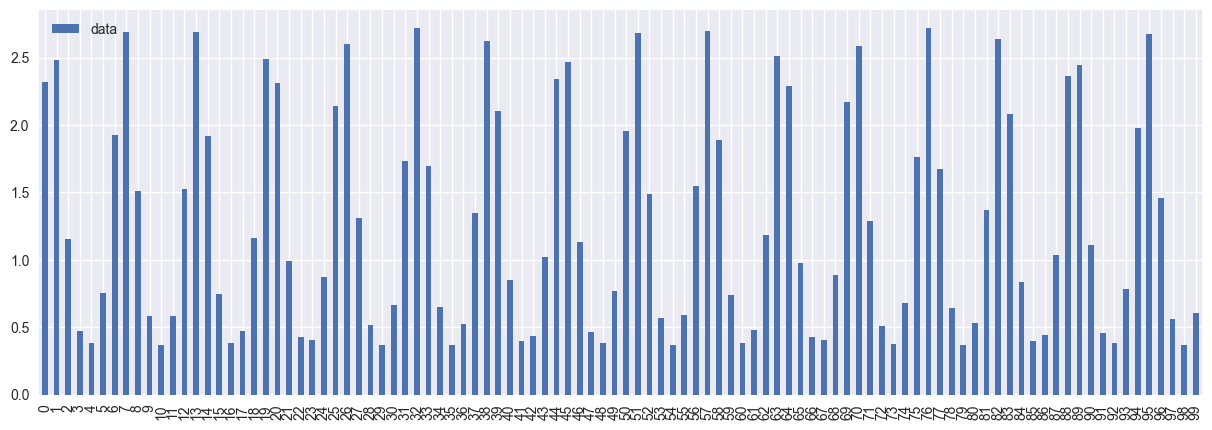

In [45]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
df = pd.DataFrame(data=x,columns=['data'])

df.plot(kind='bar', figsize=(15,5));

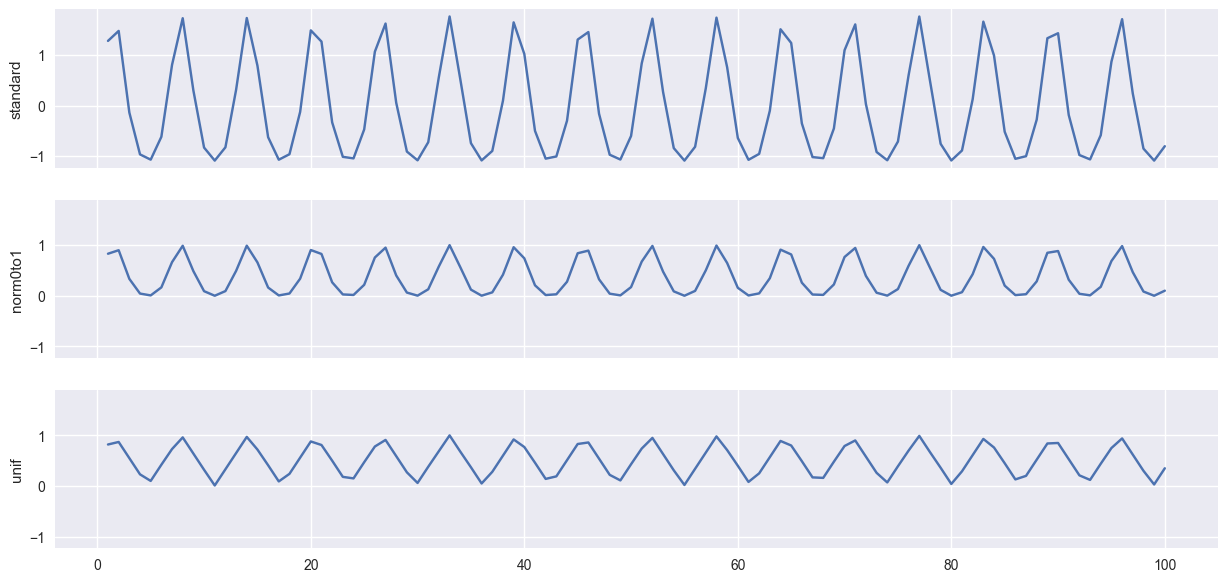

In [46]:
def norm_0to1(x):
  return ((x-np.min(x))/(np.max(x)-np.min(x)))

df = pd.DataFrame.from_dict(dict(
    index = np.linspace(1,length,length),
    standard = (x - np.mean(x))/np.std(x),
    norm0to1 = norm_0to1(x),
    unif = ECDF(x)(x)
))

fig, axs = plt.subplots(3, sharex=True, sharey=True)
for i, col in enumerate(df.columns[1:]):
  axs[i].plot(df['index'],df[col])
  axs[i].set_ylabel(col)

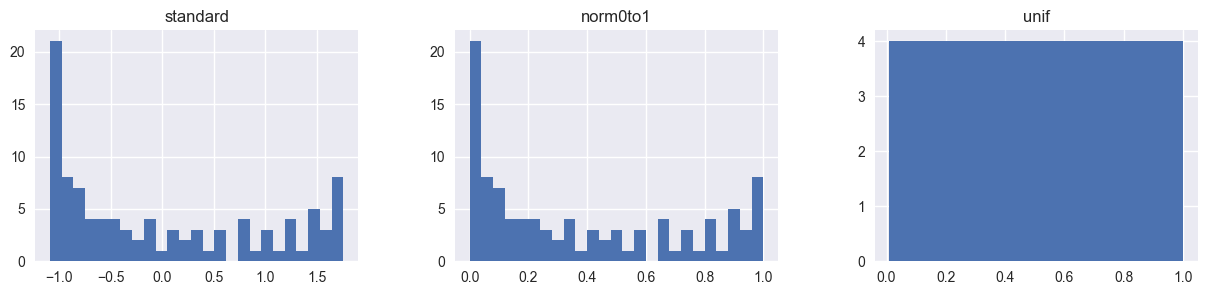

In [47]:
df.drop('index',axis=1).hist(bins=25,layout=(1,3),figsize=(15,3));

### **Chapter 5.** Penalized regressions and sparse hedging for minimum variance portfolios

In [57]:
data[features].dtypes

net_worth        float64
qnt              float64
ebit12m          float64
closed_price     float64
ativo_total      float64
fator_cotacao    float64
ret12m           float64
ret6m            float64
ret3m            float64
ret1m            float64
liq_corr         float64
vol12m           float64
dtype: object

In [58]:
y_penalized = data['ret1m'].values
X_penalized = data[features].values

alphas = np.arange(1e-3,2.5e-3,1e-4) # sklearn alpha = glmnet lambda

coef_path = {}

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_penalized,y_penalized)

  coef_path[alpha] = lasso.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta')

TypeError: no numeric data to plot

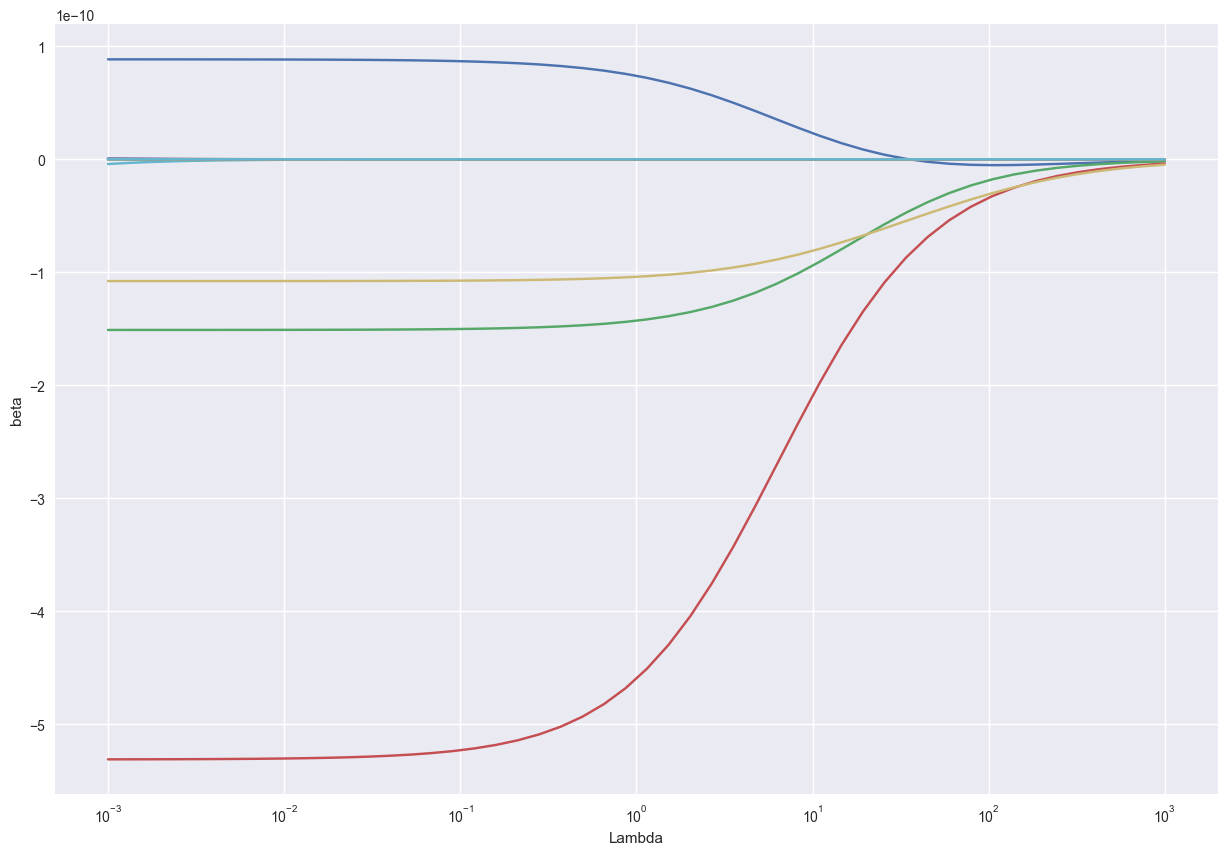

In [49]:
alphas = np.logspace(-3,3,50)

coef_path = {}

for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_penalized,y_penalized)

  coef_path[alpha] = ridge.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta',figsize=(15,10),legend=False, logx=True);

In [50]:
t_oos = returns.index[returns.index > separation_date].values

Tt = len(t_oos)
nb_port = 3

def weights_sparsehedge(returns, alpha = 0.1, l1_ratio = 0.1):

  weights = []

  lr = ElasticNet(alpha=alpha,l1_ratio=l1_ratio)

  for col in returns.columns:
    y = returns[col].values
    X = returns.drop(col, axis=1).values

    lr.fit(X,y)
    err = y - lr.predict(X)
    w = (1-np.sum(lr.coef_))/np.var(err)

    weights.append(w)

  return weights / np.sum(weights)

def weights_multi(returns, j, alpha = 0.1, l1_ratio = 0.1):

  N = returns.shape[1]

  if j == 0:
    return np.repeat(1/N,N)
  elif j == 1:
    sigma = np.cov(returns.T) + 1e-2 * np.identity(N) # hardcoded penalty....
    w = np.matmul(np.linalg.inv(sigma),np.repeat(1,N))
    return w / np.sum(w)
  elif j == 2:
    return weights_sparsehedge(returns, alpha, l1_ratio)

port_weights = {}
port_returns = {}

for t, month in np.ndenumerate(t_oos):

  temp_data = returns.loc[returns.index < month]
  realised_returns = returns.loc[returns.index == month].values

  inner_dict_weights = {}
  inner_dict_returns = {}

  for j in range(nb_port):

    wgts = weights_multi(temp_data, j, 0.1, 0.1)
    rets = np.sum(wgts * realised_returns)

    inner_dict_weights[j] = wgts
    inner_dict_returns[j] = rets

  port_weights[month] = inner_dict_weights
  port_returns[month] = inner_dict_returns

In [51]:
port_returns_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in port_returns.items()
    }, 
    axis=0).reset_index()

colnames = ['date','strategy','return']
port_returns_df.columns = colnames

stratmap = {0:'EW',1:'MV',2:'Sparse'}
port_returns_df['strategy'] = port_returns_df['strategy'].replace(stratmap)
port_returns_df.groupby('strategy')['return'].std()

strategy
EW        7.806779e-11
MV        7.806779e-11
Sparse    3.709360e-12
Name: return, dtype: float64

In [53]:
y_penalized_train = training_sample['ret1m'].values
X_penalized_train = training_sample[features].values

model = ElasticNet(alpha=0.1, l1_ratio=0.1)
model.fit(X_penalized_train,y_penalized_train)

y_penalized_test = testing_sample['ret1m'].values
X_penalized_test = testing_sample[features].values

mse = np.mean((model.predict(X_penalized_test) - y_penalized_test)**2)
hitratio = np.mean(model.predict(X_penalized_test) * y_penalized_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 5.761680187991119e-19 
Hit Ratio: 0.5265486725663717


### **Chapter 6.** Tree-based methods

In [ ]:
y = data['ret1m'].values
X = data[features].values

clf = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
clf = clf.fit(X,y)

dot_data = tree.export_graphviz(clf,out_file=None,
                                feature_names=features,
                                filled = True)

graph = graphviz.Source(dot_data)
graph

In [ ]:
cols_that_matter = []

for val in np.where(clf.feature_importances_ > 0)[0]:
  cols_that_matter.append(features[val])

cols_that_matter

temp = pd.melt(data[['ret1m']+cols_that_matter], id_vars='ret1m')

sns.lineplot(data = temp, y='ret1m', x='value', hue='variable');

In [ ]:
y_train = training_sample['ret1m'].values
X_train = training_sample[features].values

dt = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
dt.fit(X_train,y_train)

y_test = testing_sample['ret1m'].values
X_test = testing_sample[features].values

mse = np.mean((dt.predict(X_test) - y_test)**2)
hitratio = np.mean(dt.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

In [ ]:
rf = RandomForestRegressor(n_estimators=40,
                           max_features = 30,
                           min_samples_split=10000,
                           bootstrap=False)
rf.fit(X_train,y_train)

mse = np.mean((rf.predict(X_test) - y_test)**2)
hitratio = np.mean(rf.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

In [ ]:
y_train_clf = training_sample['ret1m_C']

clf = RandomForestClassifier(n_estimators=40,
                              max_features = 30,
                              min_samples_split=10000,
                              bootstrap=False)
clf.fit(X_train,y_train_clf)

y_test_clf = testing_sample['ret1m_C']

hitratio = np.mean(clf.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

In [ ]:
ada = AdaBoostClassifier()

ada.fit(X_train, y_train_clf)

hitratio = np.mean(ada.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

In [ ]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train_clf)

hitratio = np.mean(xgb.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

### **Chapter 7.** Neural networks

In [ ]:
NN_train_features = training_sample[features].values
NN_train_labels = training_sample['ret1m'].values

NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['ret1m'].values

In [ ]:
model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="tanh"),
        keras.layers.Dense(1)
    ]
)

loss_fn = keras.losses.MeanSquaredError() #regression yay
optimizer = keras.optimizers.RMSprop()

model.compile(optimizer,loss=loss_fn,metrics=['MeanAbsoluteError'])

fitted_model = model.fit(
            NN_train_features,
            NN_train_labels,
            batch_size=512,
            epochs = 10,
            validation_data=(NN_test_features,NN_test_labels),
            verbose = True
)

In [ ]:
model.summary()

In [ ]:
def plot_model_performance(mdl, loss, metric):
  x = pd.DataFrame(mdl.history).reset_index()
  x = pd.melt(x, id_vars='index')

  x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
  x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})

  g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
  g.map(sns.lineplot, 'index','value')
  g.add_legend()

  return g

plot_model_performance(fitted_model,'mean_sq_error','mean_abs_error');

In [ ]:
NN_preds = model.predict(NN_test_features, use_multiprocessing=True)
NN_preds = NN_preds.reshape(NN_preds.shape[0])

hitratio = np.mean(np.multiply(NN_preds,NN_test_labels) > 0)
print(f'Hit Ratio: {hitratio}')

In [ ]:
NN_train_labels_C = training_sample['ret1m_C'].values
NN_train_labels_C = keras.utils.to_categorical(NN_train_labels_C)

NN_test_labels_C = testing_sample['ret1m_C'].values
NN_test_labels_C = keras.utils.to_categorical(NN_test_labels_C)

In [ ]:
model_C = keras.Sequential(
    [
        keras.layers.Dense(16, 
                           activation="tanh",
                           kernel_initializer = 'random_normal',
                           kernel_constraint = keras.constraints.NonNeg()
                          ),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(8,
                           activation="elu",
                           bias_initializer = keras.initializers.Constant(value=0.2),
                           kernel_regularizer = keras.regularizers.l2(l2=0.01)
                           ),
        keras.layers.Dense(2,
                           activation = 'softmax'
                           )
    ]
)

In [ ]:
loss_fn = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.95
)

model_C.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=['categorical_accuracy']
)

fitted_model_C = model_C.fit(
            NN_train_features,
            NN_train_labels_C,
            batch_size=512,
            epochs = 20,
            validation_data=(NN_test_features,NN_test_labels_C),
            verbose = True,
            callbacks = [keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.001,
                            patience=3,
                            verbose=False
            )]
)

In [ ]:
model_C.summary()

In [ ]:
plot_model_performance(fitted_model_C,'bin_cross_entropy','categorical_accuracy');

In [ ]:
model_custom = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="sigmoid"),
        keras.layers.Dense(1)
    ]
)


def custom_loss(y_true, y_pred):
  gamma = 5

  term1 = tf.square(y_pred - tf.reduce_mean(y_pred))
  term2 = (y_true - tf.reduce_mean(y_true))*(y_pred - tf.reduce_mean(y_pred))
  
  return tf.reduce_mean(term1) - gamma * tf.reduce_mean(term2)

optimizer = keras.optimizers.RMSprop()

model_custom.compile(optimizer,loss=custom_loss,metrics=['MeanAbsoluteError'])

fitted_model_custom = model_custom.fit(
            NN_train_features,
            NN_train_labels,
            batch_size=512,
            epochs = 10,
            validation_data=(NN_test_features,NN_test_labels),
            verbose = True
)

In [ ]:
plot_model_performance(fitted_model_custom, 'custom_loss', 'mean_abs_error');

In [ ]:
NN_preds = model_custom.predict(NN_test_features, use_multiprocessing=True)
NN_preds = NN_preds.reshape(NN_preds.shape[0])

hitratio = np.mean(np.multiply(NN_preds,NN_test_labels) > 0)
print(f'Hit Ratio: {hitratio}')

In [ ]:
data_rnn = data[data['stock_id'].isin(stock_ids_short)]
training_sample_rnn = data_rnn[data_rnn['date'] < separation_date]
testing_sample_rnn = data_rnn[data_rnn['date'] > separation_date]

nb_stocks = len(stock_ids_short)
nb_feats = len(features)
nb_dates_train = training_sample_rnn.shape[0] // nb_stocks
nb_dates_test = testing_sample_rnn.shape[0] // nb_stocks

In [ ]:
nn_train_features = training_sample_rnn[features].values
train_features_rnn = np.reshape(nn_train_features, (nb_stocks, nb_dates_train, nb_feats))

nn_test_features = testing_sample_rnn[features].values
test_features_rnn = np.reshape(nn_test_features, (nb_stocks, nb_dates_test, nb_feats))

nn_train_labels = training_sample_rnn['ret1m'].values
train_labels_rnn = np.reshape(nn_train_labels, (nb_stocks, nb_dates_train, 1))

nn_test_labels = testing_sample_rnn['ret1m'].values
test_labels_rnn = np.reshape(nn_test_labels, (nb_stocks, nb_dates_test, 1))

In [ ]:
model_rnn = keras.Sequential(
    [
        keras.layers.GRU(16, batch_input_shape = (nb_stocks, nb_dates_train, nb_feats), activation='tanh'),
        keras.layers.Dense(1)
    ]
)

optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.MeanSquaredError()

model_rnn.compile(loss = loss_fn, optimizer = optimizer, metrics=['MeanAbsoluteError'])

fitted_model_rnn = model_rnn.fit(train_features_rnn,train_labels_rnn,
                                 epochs = 10, batch_size = nb_stocks)

In [ ]:
plot_model_performance(fitted_model_rnn,'mean_sq_error','mean_abs_error');

In [ ]:
new_model_rnn = keras.Sequential(
    [
        keras.layers.GRU(16, batch_input_shape = (nb_stocks, nb_dates_test, nb_feats), activation='tanh', return_sequences = True),
        keras.layers.Dense(1)
    ]
)

new_model_rnn.set_weights(model_rnn.get_weights())

In [ ]:
NN_preds = new_model_rnn.predict(test_features_rnn, batch_size = nb_stocks)

hitratio = np.mean(np.multiply(NN_preds,test_labels_rnn) > 0)
print(f'Hit Ratio: {hitratio}')

### **Chapter 8.** Support vector machines